In [1]:
import json
import numpy as np
import random
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
import soundfile
from numpy.lib.stride_tricks import as_strided

RNG_SEED = 123

In [2]:
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

In [3]:
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

def conv_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride


def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

def text_to_int_sequence(text):
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    text = []
    for c in int_sequence:
        ch = index_map.get(c,'0')
        text.append(ch)
    return text

In [4]:
class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            label = np.array(text_to_int_sequence(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)
 
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_data_by_partition(self, partition):
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def sort_data_by_duration(self, partition):
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_data(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_data(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/validation")

    def next_train(self):
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_data_by_partition('train')
            yield ret    

    def next_valid(self):
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_data_by_partition('valid')
            yield ret

    def next_test(self):
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret

    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_data_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_data_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition to load metadata. "
             "Must be train/validation/test")
            
    def fit_train(self, k_samples=100):
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
        return (feature - self.feats_mean) / (self.feats_std + eps)

def shuffle_data(audio_paths, durations, texts):
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def sort_data(audio_paths, durations, texts):
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

def vis_train_features(index=0):
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    vis_text = audio_gen.train_texts[index]
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path

def plot_mfcc_feature(vis_mfcc_feature):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

def plot_spectrogram_feature(vis_spectrogram_feature):
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

In [5]:
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2023 total training examples.


In [6]:
from IPython.display import Audio
from IPython.display import Markdown, display

display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
display(Markdown('**Transcript** : ' + str(vis_text)))
Audio(vis_audio_path)

**Shape of Audio Signal** : (218626,)

**Transcript** : shortly after passing one of these chapels we came suddenly upon a village which started up out of the mist and i was alarmed lest i should be made an object of curiosity or dislike

In [7]:
from keras import backend as K
from keras.models import Model
from keras.layers import (Bidirectional, Conv1D, Dense, Input, 
    TimeDistributed, Activation, LSTM, Lambda, GRU, BatchNormalization)

Using TensorFlow backend.
/anaconda3/envs/aind-vui/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
def rnn_model(input_dim, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = LSTM(units=128, activation='relu',
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

def final_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29, dropout_rate=0.5, number_of_layers=2, 
    cell=GRU, activation='tanh'):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Specify the layers in your network
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     # sahana change to 'sigmoid'
                     activation='relu',
                     name='layer_1_conv',
                     dilation_rate=1)(input_data)
    conv_bn = BatchNormalization(name='conv_batch_norm')(conv_1d)


    if number_of_layers == 1:
        layer = cell(units, activation=activation,
            return_sequences=True, implementation=2, name='rnn_1', dropout=dropout_rate)(conv_bn)
        layer = BatchNormalization(name='bt_rnn_1')(layer)
    else:
        layer = cell(units, activation=activation,
                    return_sequences=True, implementation=2, name='rnn_1', dropout=dropout_rate)(conv_bn)
        layer = BatchNormalization(name='bt_rnn_1')(layer)

        for i in range(number_of_layers - 2):
            layer = cell(units, activation=activation,
                        return_sequences=True, implementation=2, name='rnn_{}'.format(i+2), dropout=dropout_rate)(layer)
            layer = BatchNormalization(name='bt_rnn_{}'.format(i+2))(layer)

        layer = cell(units, activation=activation,
                    return_sequences=True, implementation=2, name='final_layer_of_rnn')(layer)
        layer = BatchNormalization(name='bt_rnn_final')(layer)
    

    time_dense = TimeDistributed(Dense(output_dim))(layer)
    # TODO: Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # TODO: Specify model.output_length
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [9]:
# model = rnn_model(input_dim=13)
model = final_model(input_dim=13,
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        # sahana I think this is no. of nodes per layer. try playing around
                        units=250,
                        # sahana change to 'sigmoid'
                        activation='relu',
                        cell=GRU,
                        dropout_rate=1,
                        number_of_layers=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
layer_1_conv (Conv1D)        (None, None, 200)         28800     
_________________________________________________________________
conv_batch_norm (BatchNormal (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 250)         338250    
_________________________________________________________________
bt_rnn_1 (BatchNormalization (None, None, 250)         1000      
_________________________________________________________________
final_layer_of_rnn (GRU)     (None, None, 250)         375750    
_________________________________________________________________
bt_rnn_final (BatchNormaliza (None, None, 250)         1000      
__________

In [10]:
import _pickle as pickle
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint   
import os
import matplotlib.pyplot as plt

In [11]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

def train_model(input_to_softmax, 
                pickle_path,
                save_model_path,
                train_json='train_corpus.json',
                valid_json='valid_corpus.json',
                minibatch_size=20,
                # sahana change to False
                spectrogram=True,
                mfcc_dim=13,
                # sahana change optimizer and learning rate from 0.001 to 0.01
#                 optimizer=SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                optimizer=Adam(lr=0.001, decay=1e-6),
                # sahana change no. of epochs finally
                epochs=2,
                verbose=1,
                sort_by_duration=False,
                max_duration=10.0):
    
    # create a class instance for obtaining batches of data
    audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)
    # add the training data to the generator
    audio_gen.load_train_data(train_json)
    audio_gen.load_validation_data(valid_json)
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    
    #sahana change and check with loss='mse' and ctc
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])
#     model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    # make results/ directory, if necessary
    if not os.path.exists('results'):
        os.makedirs('results')

    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)
    
    print(hist.history.keys())
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # save model loss
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

In [12]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

Epoch 1/2
101/101 [==============================] - 374s - loss: 254.8681 - acc: 0.0000e+00 - val_loss: 294.8668 - val_acc: 0.0000e+00
Epoch 2/2
101/101 [==============================] - 384s - loss: 209.6070 - acc: 0.0000e+00 - val_loss: 230.7498 - val_acc: 0.0000e+00
dict_keys(['loss', 'acc', 'val_acc', 'val_loss'])


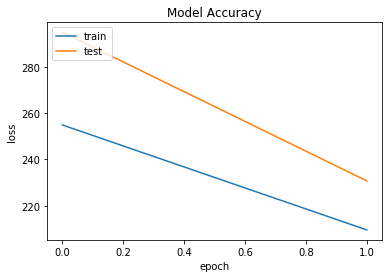

In [13]:
# np.fft.restore_all()

# train_model(input_to_softmax=model, 
#             pickle_path='model.pickle', 
#             save_model_path='model.h5',
#             spectrogram=False)

train_model(input_to_softmax=model, 
            pickle_path='model.pickle',
            save_model_path='model.h5', 
            spectrogram=False)

In [14]:
def get_predictions(index, partition, input_to_softmax, model_path):
    # load the train and test data
    data_gen = AudioGenerator(spectrogram=False)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print(pred_ints)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

In [15]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=model, 
                model_path='results/model.h5')

--------------------------------------------------------------------------------
True transcription:

shortly after passing one of these chapels we came suddenly upon a village which started up out of the mist and i was alarmed lest i should be made an object of curiosity or dislike
--------------------------------------------------------------------------------
[]
Predicted transcription:


--------------------------------------------------------------------------------
